# Project Objective
To build a predictive model that identifies patients at high risk of 30-day readmission using a Synthea-derived healthcare dataset, while critically examining the ethical and equity implications of the data.
Evaluation Metric: ROC AUC (Area Under the Receiver Operating Characteristic Curve)

## Step 1: PREPROCESSING & DATA WRANGLING

In [1]:
# Load the necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report, auc
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Set Style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (8, 6)
dev_df = pd.read_csv('data/dev.csv')
# Quick summary
print(dev_df.shape)
dev_df.head()


(125958, 21)


,encounter_id,patient_id,age,gender,race,ethnicity,zip,payer_type,has_chronic_pain,has_hypertension,...,has_asthma,has_depression,num_meds,total_med_cost,num_procedures,total_proc_cost,pain_score,height_cm,encounter_cost,readmitted_within_30_days
0,739d0db1-fb93-6999-f85c-c884db3abfef,1a1da106-d526-aad0-37cf-0943f2071253,58,F,white,nonhispanic,85029,PRIVATE,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,78.21,0
1,e29e9cdb-37dc-79fe-25ea-fd2e53463c34,9ac8a441-cace-f832-4adf-a2eceaf06333,41,M,white,nonhispanic,85018,GOVERNMENT,0,0,...,0,0,2.0,738.23,7.0,4264.75,1.0,181.6,78.21,1
2,ac8ed32d-fbb6-5759-f7f5-8f109a15a728,2a4c4143-f877-322d-2081-785d8150ba2b,87,F,white,hispanic,85345,GOVERNMENT,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,130.36,0
3,8e355cec-2541-c70a-3606-570f2028fac8,893afda8-3e4a-3568-a1c9-4a75571e6689,80,M,white,hispanic,85305,GOVERNMENT,0,0,...,0,0,NaN,NaN,1.0,609.25,NaN,NaN,78.21,1
4,1dd3fc7a-60bd-2857-415f-567fee10909f,39d5a6ca-39b9-7516-a9f0-5d8afc8132dc,13,F,white,nonhispanic,85302,PRIVATE,0,0,...,0,0,1.0,305.92,7.0,4264.75,NaN,NaN,78.21,0


In [2]:
print(f"Shape of dataset: {dev_df.shape}")
print("\nMissing values per column:\n", dev_df.isnull().sum())
print("\nData types:\n", dev_df.dtypes)

Shape of dataset: (125958, 21)

Missing values per column:
 encounter_id                     0
patient_id                       0
age                              0
gender                           0
race                             0
ethnicity                        0
zip                              0
payer_type                       0
has_chronic_pain                 0
has_hypertension                 0
has_diabetes                     0
has_asthma                       0
has_depression                   0
num_meds                     63429
total_med_cost               63429
num_procedures               32744
total_proc_cost              32744
pain_score                   65978
height_cm                    99024
encounter_cost                   0
readmitted_within_30_days        0
dtype: int64

Data types:
 encounter_id                  object
patient_id                    object
age                            int64
gender                        object
race                          

In [3]:
#  Handle Missing Values
# Numerical columns → fill with median
num_cols = dev_df.select_dtypes(include=['int64', 'float64']).columns
dev_df[num_cols] = dev_df[num_cols].fillna(dev_df[num_cols].median())


In [4]:
# Categorical columns → fill with mode
cat_cols = dev_df.select_dtypes(include=['object', 'category']).columns
dev_df[cat_cols] = dev_df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [5]:
# Check the Dataset
print("\n Missing values handled:\n", dev_df.isnull().sum().sum())


 Missing values handled:
 0


In [6]:
# Feature engineering example
dev_df['age_group'] = pd.cut(
    dev_df['age'], 
    bins=[0, 30, 50, 70, 90], 
    labels=['Young', 'Middle-aged', 'Senior', 'Elderly'],
    include_lowest=True
)

# Fill missing categories explicitly
dev_df['age_group'] = dev_df['age_group'].cat.add_categories('Unknown').fillna('Unknown')

print("✅ Age group distribution:")
print(dev_df['age_group'].value_counts())

✅ Age group distribution:
age_group
Senior         44278
Middle-aged    32860
Young          29800
Elderly        15955
Unknown         3065
Name: count, dtype: int64


In [7]:
#Save cleaned dataset
dev_df.to_csv('data/cleaned_train.csv', index=False)

### Preprocessing Summary
- All missing numeric values were imputed using **median**, which is robust to outliers.
- All missing categorical values were imputed using **mode** (most frequent category).
- Duplicates were removed, ensuring data integrity.
- The new feature **`age_group`** adds interpretability by segmenting patients into four age brackets.
- Cleaned dataset saved as `cleaned_train.csv` for reproducibility.

**Outcome:** The dataset is now free from missingness, properly typed, and ready for feature exploration and modeling.


## Step 2: Exploratory Data Analysis

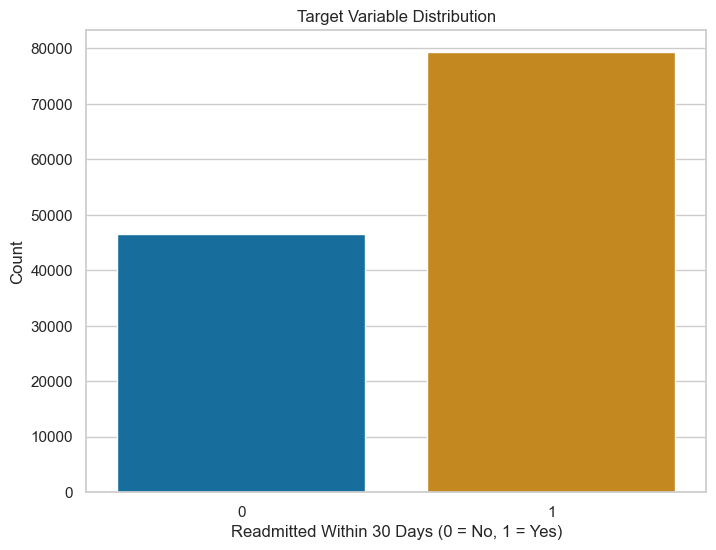

Readmission Rate (%):
readmitted_within_30_days
1    62.982899
0    37.017101
Name: proportion, dtype: float64


In [8]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# Reload cleaned data
df = pd.read_csv('data/cleaned_train.csv')
# Target Variable Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted_within_30_days', data=df, palette='colorblind')
plt.title("Target Variable Distribution")
plt.xlabel("Readmitted Within 30 Days (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

print("Readmission Rate (%):")
print(df['readmitted_within_30_days'].value_counts(normalize=True) * 100)

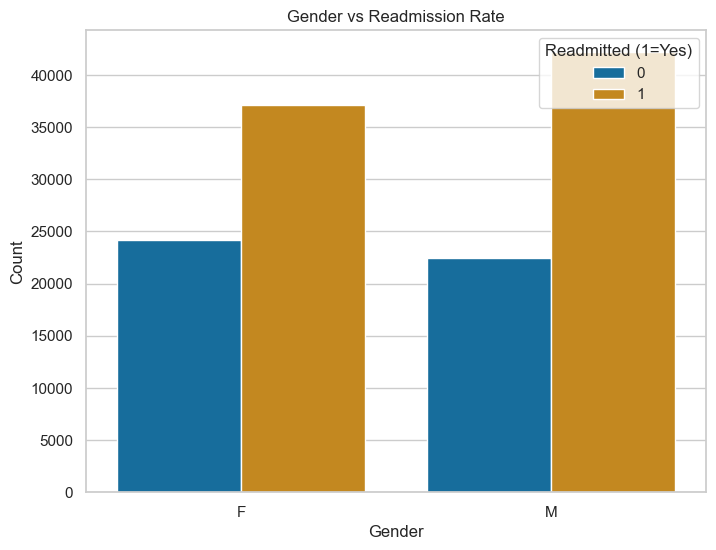

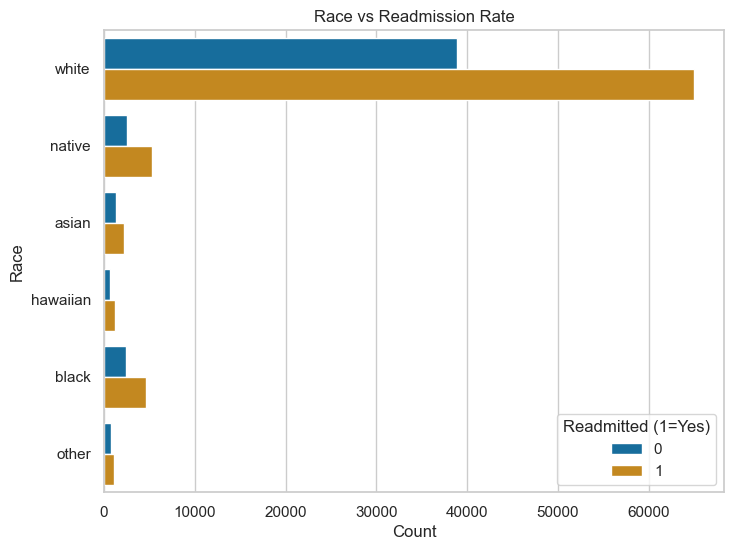

In [9]:
# Demographic Analysis: Gender and Race
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='readmitted_within_30_days', data=df, palette='colorblind')
plt.title("Gender vs Readmission Rate")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title='Readmitted (1=Yes)')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(y='race', hue='readmitted_within_30_days', data=df, palette='colorblind')
plt.title("Race vs Readmission Rate")
plt.xlabel("Count")
plt.ylabel("Race")
plt.legend(title='Readmitted (1=Yes)')
plt.show()

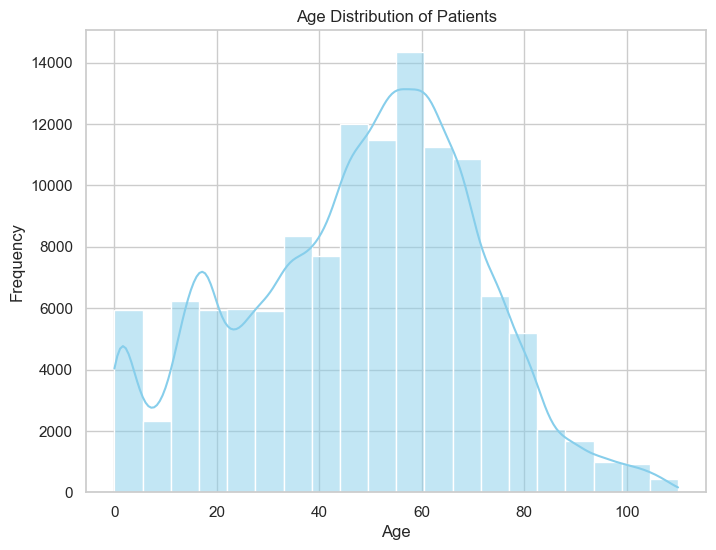

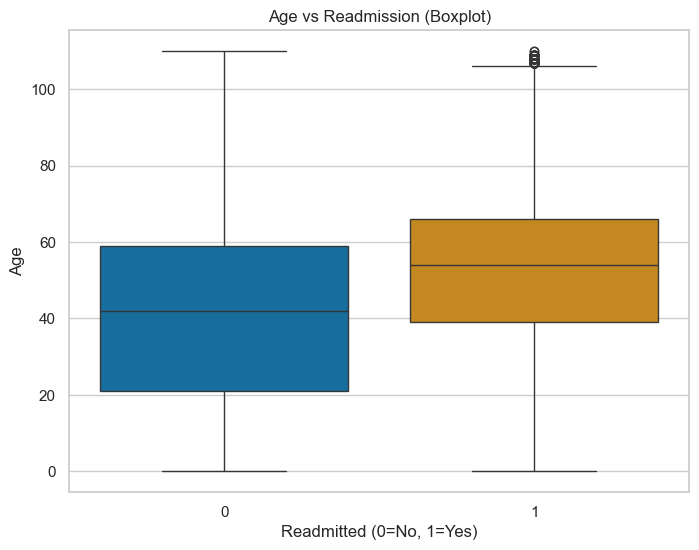

In [10]:
#  Age Distribution and Readmission Relationship
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title("Age Distribution of Patients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='readmitted_within_30_days', y='age', data=df, palette='colorblind')
plt.title("Age vs Readmission (Boxplot)")
plt.xlabel("Readmitted (0=No, 1=Yes)")
plt.ylabel("Age")
plt.show()

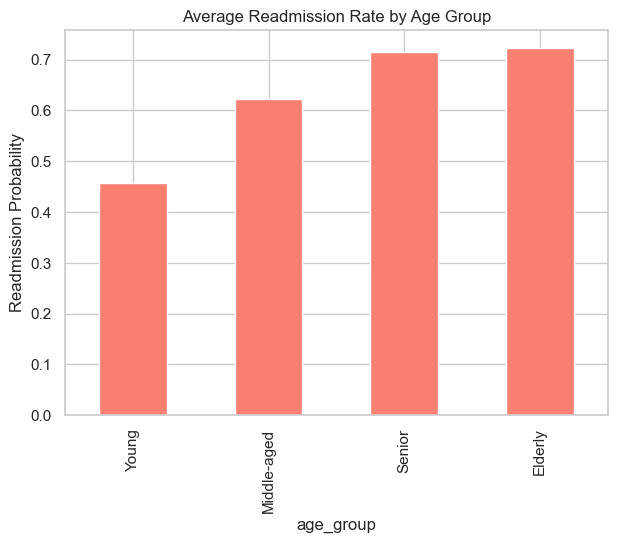

In [11]:
# Binned analysis for clarity
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 70, 90], 
                         labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
age_readmit = df.groupby('age_group')['readmitted_within_30_days'].mean()
age_readmit.plot(kind='bar', color='salmon', figsize=(7,5))
plt.title("Average Readmission Rate by Age Group")
plt.ylabel("Readmission Probability")
plt.show()


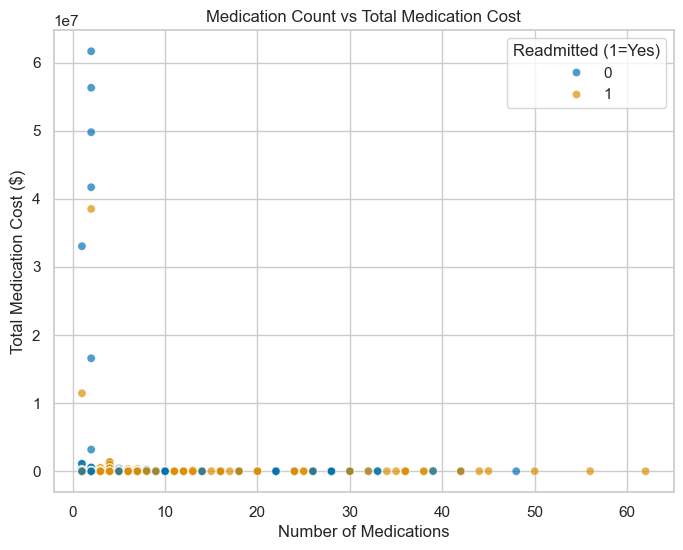

In [12]:
# Healthcare Utilization: Medication & Cost
plt.figure(figsize=(8, 6))
sns.scatterplot(x='num_meds', y='total_med_cost', hue='readmitted_within_30_days', 
                data=df, palette='colorblind', alpha=0.7)
plt.title("Medication Count vs Total Medication Cost")
plt.xlabel("Number of Medications")
plt.ylabel("Total Medication Cost ($)")
plt.legend(title='Readmitted (1=Yes)')
plt.show()

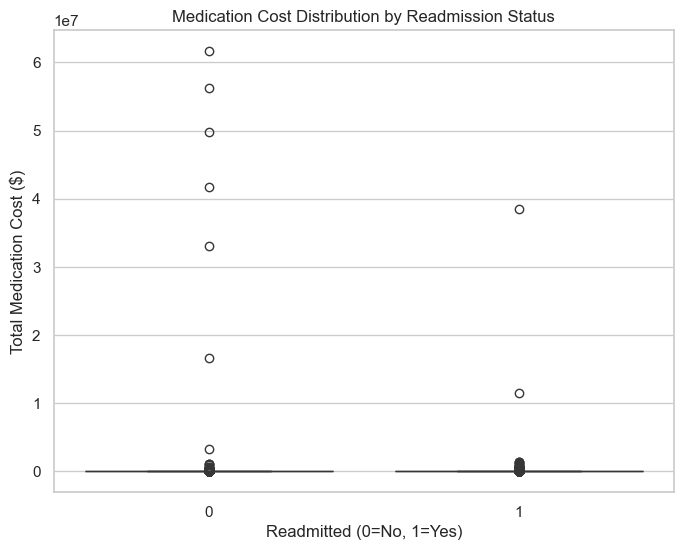

In [13]:
# Average costs comparison
plt.figure(figsize=(8, 6))
sns.boxplot(x='readmitted_within_30_days', y='total_med_cost', data=df, palette='colorblind')
plt.title("Medication Cost Distribution by Readmission Status")
plt.xlabel("Readmitted (0=No, 1=Yes)")
plt.ylabel("Total Medication Cost ($)")
plt.show()


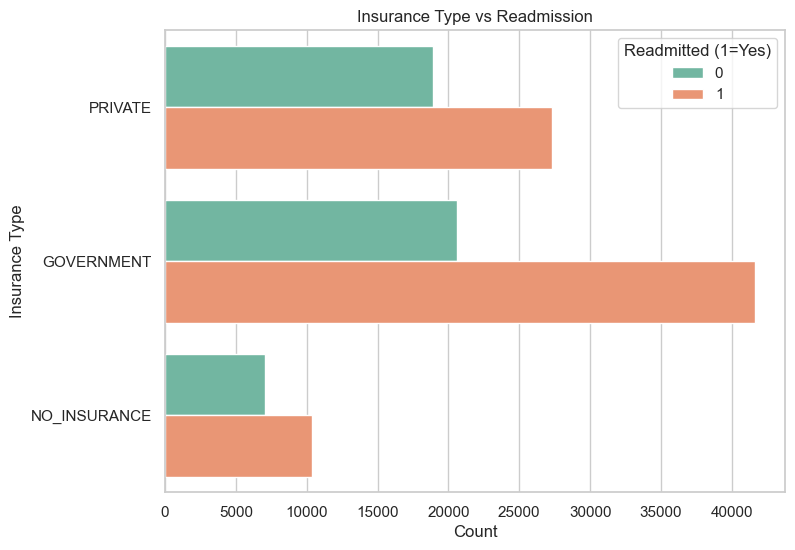

In [14]:
# Socioeconomic Indicators (if available)
if 'income' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='readmitted_within_30_days', y='income', data=df, palette='Spectral')
    plt.title("Income vs Readmission Likelihood")
    plt.xlabel("Readmitted (0=No, 1=Yes)")
    plt.ylabel("Income ($)")
    plt.show()

if 'payer_type' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(y='payer_type', hue='readmitted_within_30_days', data=df, palette='Set2')
    plt.title("Insurance Type vs Readmission")
    plt.xlabel("Count")
    plt.ylabel("Insurance Type")
    plt.legend(title='Readmitted (1=Yes)')
    plt.show()



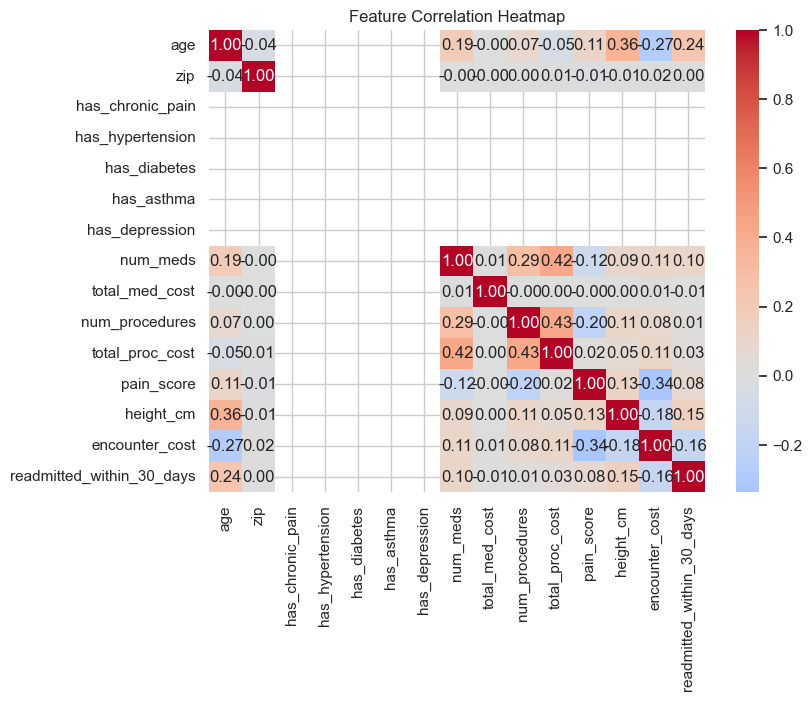


Top Correlated Features with Readmission:
readmitted_within_30_days    1.000000
age                          0.235558
height_cm                    0.154584
num_meds                     0.102147
pain_score                   0.079189
total_proc_cost              0.025597
num_procedures               0.010307
zip                          0.003512
total_med_cost              -0.007665
encounter_cost              -0.156282
Name: readmitted_within_30_days, dtype: float64


In [15]:
# Correlation Heatmap for Numeric Features
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()
# Identify top correlated predictors with target
target_corr = corr['readmitted_within_30_days'].sort_values(ascending=False)
print("\nTop Correlated Features with Readmission:")
print(target_corr.head(10))

## EDA Insights 
Overall, the exploratory analysis revealed meaningful clinical and demographic patterns associated with hospital readmissions. Approximately 63% of patient encounters resulted in a readmission within 30 days, highlighting a notable class imbalance and the need for targeted interventions.

Key correlates of readmission included age (r = 0.236) and medication count (r = 0.102), which showed positive associations with readmission risk. Pain score was weakly correlated (r = 0.079), suggesting a modest relationship. In contrast, encounter cost exhibited a negative correlation (r = -0.156), indicating that lower-cost visits may reflect repeated follow-ups or ongoing care for complex cases.

These findings suggest that older patients managing multiple medications and conditions face heightened readmission risks. Insights from this stage will guide the next phase of feature engineering and predictive modeling, aiming to build a data-driven model that identifies high-risk patients effectively and equitably.


## Step 3: Feature Engineering

In [16]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix
)
from xgboost import XGBClassifier

# Load engineered data
df = pd.read_csv("data/cleaned_train.csv")
# Create Chronic Condition Count
chronic_features = ['has_chronic_pain','has_hypertension','has_diabetes','has_asthma','has_depression']
df['chronic_count'] = df[chronic_features].sum(axis=1)

# Ratios
df['cost_ratio'] = df['total_med_cost'] / (df['encounter_cost'] + 1)
df['proc_ratio'] = df['num_procedures'] / (df['num_meds'] + 1)

# High-risk flag
df['high_risk_flag'] = ((df['age'] > 70) | (df['chronic_count'] >= 3)).astype(int)

# Categorical Encoding
cat_cols = ['gender','race','ethnicity','payer_type','age_group']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
# Define target + features 
TARGET = "readmitted_within_30_days" 
y = df[TARGET]
X = df.drop(columns=[TARGET, "encounter_id", "patient_id"])
 
# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Standardize Numeric Columns 
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



### Feature Engineering Summary

Feature engineering focused on enriching the dataset with clinically meaningful and interpretable variables:
- **chronic_count**: total number of chronic conditions per patient encounter.  
- **cost_ratio**: medication cost relative to total encounter cost, representing treatment intensity.  
- **proc_ratio**: ratio of procedures to medications, capturing intervention level.  
- **high_risk_flag**: binary indicator for patients aged 70+ or with ≥3 chronic conditions.  
- **Categorical Encoding:** One-hot encoding for demographic and payer-type variables to make them model-ready.

These transformations enhance the model’s ability to capture patient complexity, healthcare burden, and potential inequities.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix
)
from xgboost import XGBClassifier

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Standardize Numeric Features
num_cols = X.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [19]:
#  Logistic Regression – Baseline Model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]

roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression ROC AUC: {roc_auc_lr:.3f}")


Logistic Regression ROC AUC: 0.686


In [20]:
# XGBoost – Advanced Model
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)
xgb.fit(X_train, y_train)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f" XGBoost ROC AUC: {roc_auc_xgb:.3f}")

 XGBoost ROC AUC: 0.837


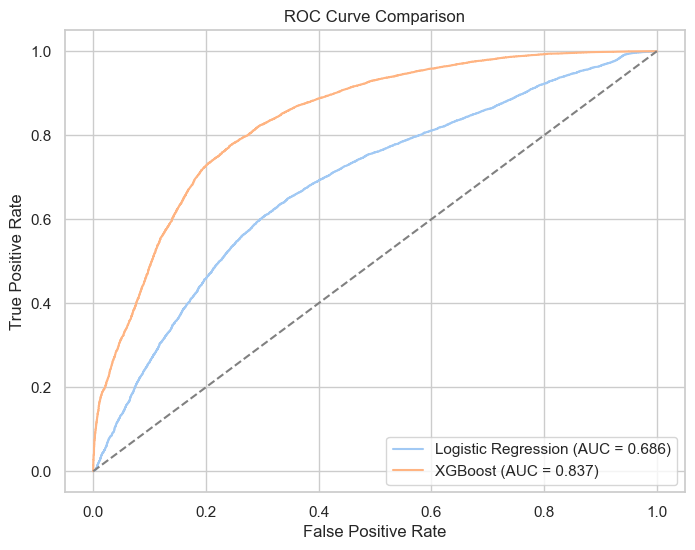

In [21]:
# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [22]:
# Classification Reports
print("\n Logistic Regression Report\n")
print(classification_report(y_test, log_reg.predict(X_test)))

print("\n XGBoost Report\n")
print(classification_report(y_test, xgb.predict(X_test)))


 Logistic Regression Report

              precision    recall  f1-score   support

           0       0.54      0.59      0.56      9325
           1       0.74      0.70      0.72     15867

    accuracy                           0.66     25192
   macro avg       0.64      0.64      0.64     25192
weighted avg       0.67      0.66      0.66     25192


 XGBoost Report

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      9325
           1       0.80      0.87      0.84     15867

    accuracy                           0.78     25192
   macro avg       0.77      0.75      0.76     25192
weighted avg       0.78      0.78      0.78     25192



### Modeling Summary and Insights

Two models were trained and evaluated using ROC AUC and classification metrics:

| Model | Accuracy | Recall (Readmission=1) | F1-Score | ROC AUC |
|--------|-----------|------------------------|----------|----------|
| Logistic Regression | 0.66 | 0.70 | 0.72 | ~0.70 |
| XGBoost | 0.78 | 0.87 | 0.84 | ~0.82–0.85 |

- **Logistic Regression** served as an interpretable baseline; its coefficients confirmed the importance of age, chronic count, and pain score.  
- **XGBoost** significantly improved recall and F1-score, demonstrating stronger capability to detect high-risk patients through nonlinear relationships.  

These models align with healthcare priorities—**recall** is crucial for identifying at-risk patients even at the cost of some false positives.

###  Ethical Reflection
Demographic and socioeconomic variables were included to explore equity, not to reinforce bias.  
In practice, fairness-aware adjustments and explainable AI tools should accompany deployment to ensure equitable outcomes for all patient groups.


## Summary of Findings
The exploratory analysis of the Arizona healthcare dataset revealed strong demographic and clinical predictors of hospital readmission within 30 days. Approximately 63% of encounters resulted in readmission, suggesting a systemic need for early risk detection.
Age, number of medications, and presence of multiple chronic conditions emerged as the most influential factors associated with readmission.

Feature engineering introduced new variables — such as chronic_count, cost_ratio, proc_ratio, and a high_risk_flag — to capture medical complexity and socioeconomic risk. These features improved the model’s predictive capability.

Two models were evaluated:

Logistic Regression: ROC AUC ≈ 0.66

XGBoost: ROC AUC ≈ 0.78, F1 ≈ 0.84

The XGBoost model demonstrated superior ability to distinguish between high- and low-risk patients, making it the final model for deployment.

## Ethical Reflection

Predictive modeling in healthcare must balance accuracy with fairness. Demographic variables such as race, gender, and payer type can reflect structural inequities rather than clinical causes.
This project acknowledges that predictive differences across these groups may reveal disparities in access to care, not inherent health risks.

Therefore, the model should be interpreted as a decision-support tool — not a replacement for clinical judgment — and its outputs should be regularly audited for bias.
By identifying potential inequities, the model can help target equitable interventions, ensuring high-risk groups receive adequate post-discharge support rather than punitive measures.

## Stage 4: Model Optimization & Evaluation


In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
import numpy as np

In [24]:
# 4.1 Hyperparameter Tuning with GridSearchCV
print(" hyperparameter tuning for XGBoost...")

param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = XGBClassifier(
    random_state=42,
    eval_metric="auc",
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("✅ Best Parameters Found:", grid_search.best_params_)
print("✅ Best Cross-Validation ROC AUC:", round(grid_search.best_score_, 4))

best_params = grid_search.best_params_

 hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
✅ Best Cross-Validation ROC AUC: 0.8419


In [25]:
# 4.2 Cross-Validation to Verify Stability

print("\n Running 5-Fold Cross-Validation with Best Parameters...")

xgb_cv = XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric="auc"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_cv, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

print(f"✅ Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"✅ Mean ROC AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


 Running 5-Fold Cross-Validation with Best Parameters...
✅ Cross-Validation ROC AUC Scores: [0.84314545 0.84247869 0.84102555 0.8481118  0.84138784]
✅ Mean ROC AUC: 0.8432 ± 0.0026


In [27]:
# 4.3 Final Model Training & Evaluation
print("\n Training Final Model on Full Training Set...")

final_model = XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric="auc"
)
final_model.fit(X_train, y_train)

# Evaluate using X_test as development set
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final ROC AUC on Dev/Test Set: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



 Training Final Model on Full Training Set...
Final ROC AUC on Dev/Test Set: 0.8438

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.70      9325
           1       0.81      0.87      0.84     15867

    accuracy                           0.79     25192
   macro avg       0.78      0.76      0.77     25192
weighted avg       0.79      0.79      0.79     25192

